Simulate and analyze AR, MA, ARMA, ARIMA, SARIMA models
- Generate time series data then compute ACF and PACF.
- Determine model orders.
- Compare empiric ACF and PACF with theoretical counterpart.
- Estimate the model parameters from the generated data.

Model real-world time series
- Is differencing required?
- Determine model order from ACF and PACF (review this summary).
- Estimate the model parameters.

,model,aic_min_order,bic_min_order,seasonal_lag,seasonal_flags
0,AR(2),"(2, 3)","(2, 0)",NaN,NaN
1,MA(2),"(0, 2)","(0, 2)",NaN,NaN
2,"ARMA(1,1)","(0, 2)","(1, 0)",NaN,NaN
3,"ARIMA(1,1,1)","(2, 0)","(1, 0)",NaN,NaN
4,"SARIMA(1,1,1)x(1,1,1)_12","(3, 2)","(0, 1)",12.0,"(1, 1)"


,model,parameter,true,estimated,abs_error
0,AR(2),phi1,0.6,0.599640,0.000360
1,AR(2),phi2,-0.2,-0.209984,0.009984
2,"ARIMA(1,1,1)",phi1,0.5,0.531958,0.031958
3,"ARIMA(1,1,1)",theta1,-0.3,-0.291783,0.008217
4,"ARMA(1,1)",phi1,0.5,0.280309,0.219691
5,"ARMA(1,1)",theta1,-0.4,-0.042769,0.357231
6,MA(2),theta1,0.5,0.425338,0.074662
7,MA(2),theta2,0.3,0.277750,0.022250
8,"SARIMA(1,1,1)x(1,1,1)_12",Phi1,0.3,NaN,NaN
9,"SARIMA(1,1,1)x(1,1,1)_12",Theta1,-0.4,NaN,NaN


,model,acf_rmse,pacf_rmse
0,AR(2),0.055783,0.040027
1,MA(2),0.046268,0.040549
2,"ARMA(1,1)",0.047584,0.050858
3,"ARIMA(1,1,1)",0.052277,0.049717
4,"SARIMA(1,1,1)x(1,1,1)_12",0.055053,0.050178


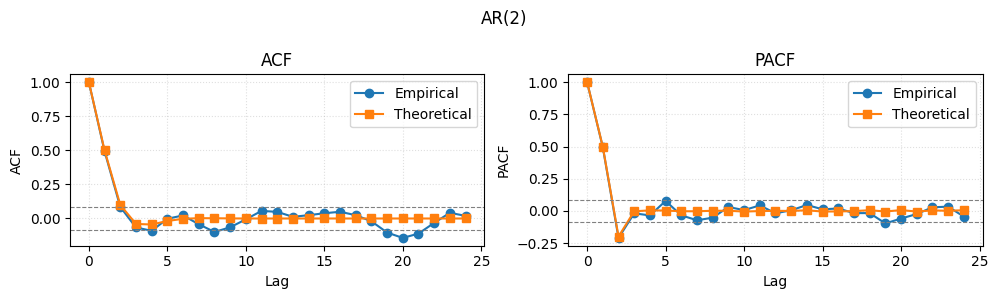

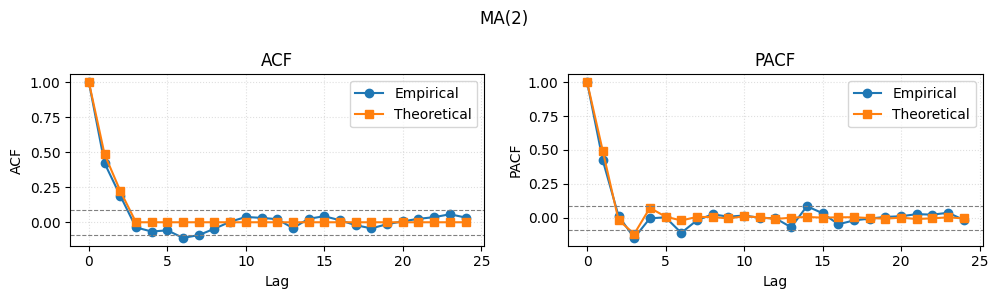

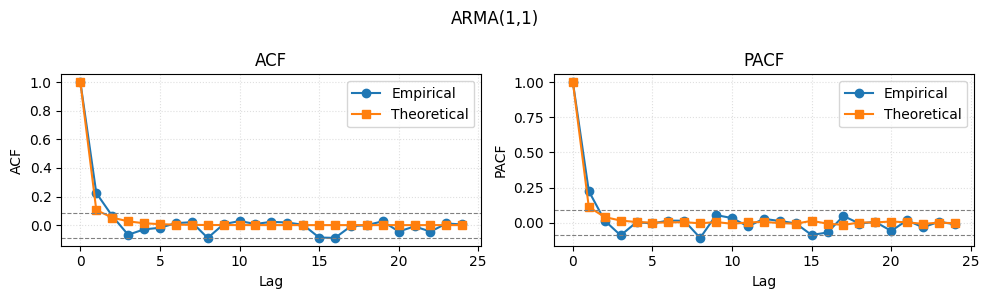

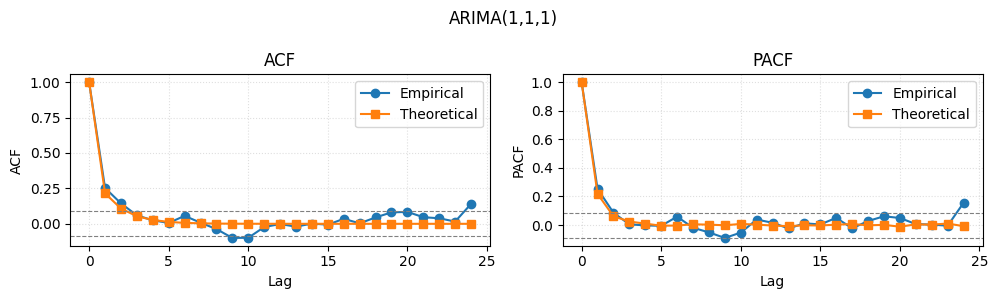

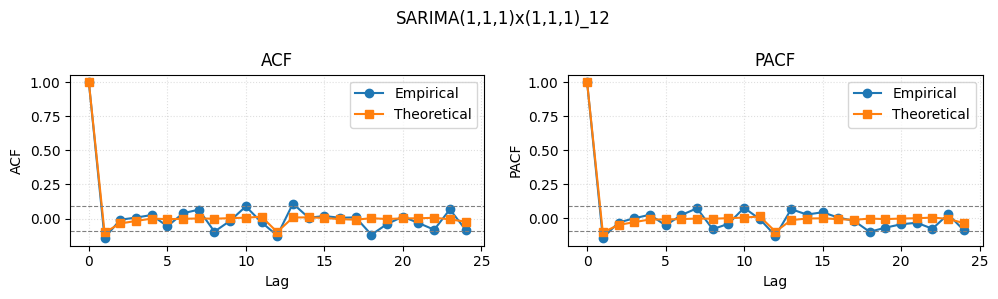

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf, arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA

np.random.seed(42)

NLAGS = 24
N = 500

MODEL_CONFIGS = [
    {
        "name": "AR(2)",
        "ar_params": [0.6, -0.2],
        "ma_params": [],
        "d": 0,
        "seasonal": None,
        "fit_order": (2, 0, 0),
        "true_params": {"phi1": 0.6, "phi2": -0.2},
    },
    {
        "name": "MA(2)",
        "ar_params": [],
        "ma_params": [0.5, 0.3],
        "d": 0,
        "seasonal": None,
        "fit_order": (0, 0, 2),
        "true_params": {"theta1": 0.5, "theta2": 0.3},
    },
    {
        "name": "ARMA(1,1)",
        "ar_params": [0.5],
        "ma_params": [-0.4],
        "d": 0,
        "seasonal": None,
        "fit_order": (1, 0, 1),
        "true_params": {"phi1": 0.5, "theta1": -0.4},
    },
    {
        "name": "ARIMA(1,1,1)",
        "ar_params": [0.5],
        "ma_params": [-0.3],
        "d": 1,
        "seasonal": None,
        "fit_order": (1, 1, 1),
        "true_params": {"phi1": 0.5, "theta1": -0.3},
    },
    {
        "name": "SARIMA(1,1,1)x(1,1,1)_12",
        "ar_params": [0.4],
        "ma_params": [-0.5],
        "d": 1,
        "seasonal": {
            "order": (1, 1, 1),
            "period": 12,
            "params": [0.4, -0.5, 0.3, -0.4, 1.0],
            "fit_order": (1, 1, 1, 12),
        },
        "fit_order": (1, 1, 1),
        "true_params": {"phi1": 0.4, "theta1": -0.5, "Phi1": 0.3, "Theta1": -0.4},
    },
]


def build_process(ar_params=None, ma_params=None):
    ar_params = np.array(ar_params or [], dtype=float)
    ma_params = np.array(ma_params or [], dtype=float)
    ar_poly = np.r_[1.0, -ar_params]
    ma_poly = np.r_[1.0, ma_params]
    return ArmaProcess(ar_poly, ma_poly)


def approx_theoretical_pacf(process, lags, nsample=40000):
    synthetic = process.generate_sample(nsample=nsample)
    return pacf(synthetic, nlags=lags, method="yw")


def compute_acf_pacf(series, lags):
    acf_vals = acf(series, nlags=lags, fft=True)
    pacf_vals = pacf(series, nlags=lags, method="yw")
    return pd.DataFrame({"lag": np.arange(lags + 1), "acf": acf_vals, "pacf": pacf_vals})


def difference_series(series, d=0, D=0, s=1):
    result = series.copy()
    for _ in range(d):
        result = result.diff().dropna()
    for _ in range(D):
        result = result.diff(s).dropna()
    return result


def simulate_sarima_series(params, order, seasonal_order, n):
    model = ARIMA([0], order=order, seasonal_order=seasonal_order, trend="n")
    sample = model.simulate(params, nsimulations=n)
    return sample


def compute_threshold(sample_size):
    return 1.96 / np.sqrt(sample_size)


def plot_acf_pacf_comparison(comparison, title, threshold):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    for ax, col in zip(axes, ["acf", "pacf"]):
        emp = f"{col}_empirical"
        theo = f"{col}_theoretical"
        ax.plot(comparison["lag"], comparison[emp], marker="o", label="Empirical")
        ax.plot(comparison["lag"], comparison[theo], marker="s", label="Theoretical")
        ax.axhline(threshold, color="gray", linestyle="--", linewidth=0.8)
        ax.axhline(-threshold, color="gray", linestyle="--", linewidth=0.8)
        ax.set_title(col.upper())
        ax.set_xlabel("Lag")
        ax.set_ylabel(col.upper())
        ax.grid(True, linestyle=":", alpha=0.4)
        ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()


results = []
order_rows = []
param_rows = []

for config in MODEL_CONFIGS:
    name = config["name"]
    seasonal_cfg = config.get("seasonal")
    if seasonal_cfg is None:
        process = build_process(config.get("ar_params"), config.get("ma_params"))
        stationary_raw = process.generate_sample(nsample=N)
        stationary_series = pd.Series(stationary_raw[-N:], name=f"{name} (stationary)")
        if config["d"] > 0:
            level_series = stationary_series.copy()
            for _ in range(config["d"]):
                level_series = level_series.cumsum()
            series = level_series.rename(name)
        else:
            series = stationary_series.rename(name)
        theoretical_acf = process.acf(NLAGS + 1)[: NLAGS + 1]
        theoretical_pacf = approx_theoretical_pacf(process, NLAGS)
    else:
        order = config["fit_order"]
        seasonal_order = seasonal_cfg["fit_order"]
        sarima_raw = simulate_sarima_series(seasonal_cfg["params"], order, seasonal_order, N)
        series = pd.Series(sarima_raw[-N:], name=name)
        stationary_series = difference_series(
            series, d=config["d"], D=seasonal_cfg["order"][1], s=seasonal_cfg["period"]
        )
        theoretical_long = simulate_sarima_series(seasonal_cfg["params"], order, seasonal_order, 60000)
        theoretical_stationary = difference_series(
            pd.Series(theoretical_long), d=config["d"], D=seasonal_cfg["order"][1], s=seasonal_cfg["period"]
        )
        theoretical_acf = acf(theoretical_stationary, nlags=NLAGS, fft=True)
        theoretical_pacf = pacf(theoretical_stationary, nlags=NLAGS, method="yw")

    empirical_df = compute_acf_pacf(stationary_series, NLAGS).rename(
        columns={"acf": "acf_empirical", "pacf": "pacf_empirical"}
    )
    theoretical_df = pd.DataFrame(
        {
            "lag": np.arange(NLAGS + 1),
            "acf_theoretical": theoretical_acf,
            "pacf_theoretical": theoretical_pacf,
        }
    )
    comparison = empirical_df.merge(theoretical_df, on="lag")
    comparison["acf_diff"] = comparison["acf_empirical"] - comparison["acf_theoretical"]
    comparison["pacf_diff"] = comparison["pacf_empirical"] - comparison["pacf_theoretical"]
    threshold = compute_threshold(len(stationary_series))

    results.append(
        {
            "name": name,
            "series": series,
            "stationary": stationary_series,
            "comparison": comparison,
            "threshold": threshold,
        }
    )

    order_info = arma_order_select_ic(
        stationary_series.values, max_ar=4, max_ma=4, ic=["aic", "bic"], trend="n"
    )
    order_row = {
        "model": name,
        "aic_min_order": order_info.aic_min_order,
        "bic_min_order": order_info.bic_min_order,
    }
    if seasonal_cfg is not None:
        seasonal_lag = seasonal_cfg["period"]
        order_row["seasonal_lag"] = seasonal_lag
        if seasonal_lag <= NLAGS:
            pacf_val = comparison.loc[comparison["lag"] == seasonal_lag, "pacf_empirical"].to_numpy()
            acf_val = comparison.loc[comparison["lag"] == seasonal_lag, "acf_empirical"].to_numpy()
            order_row["seasonal_flags"] = (
                int(pacf_val.size > 0 and np.abs(pacf_val[0]) > threshold),
                int(acf_val.size > 0 and np.abs(acf_val[0]) > threshold),
            )
        else:
            order_row["seasonal_flags"] = (np.nan, np.nan)
    order_rows.append(order_row)

    if seasonal_cfg is None:
        fit = ARIMA(
            series,
            order=config["fit_order"],
            trend="n",
            enforce_stationarity=False,
            enforce_invertibility=False,
        ).fit()
    else:
        fit = ARIMA(
            series,
            order=config["fit_order"],
            seasonal_order=seasonal_cfg["fit_order"],
            trend="n",
            enforce_stationarity=False,
            enforce_invertibility=False,
        ).fit()

    estimated_params = {}
    if hasattr(fit, "arparams") and fit.arparams.size:
        for idx, val in enumerate(np.atleast_1d(fit.arparams), start=1):
            estimated_params[f"phi{idx}"] = float(val)
    if hasattr(fit, "maparams") and fit.maparams.size:
        for idx, val in enumerate(np.atleast_1d(fit.maparams), start=1):
            estimated_params[f"theta{idx}"] = float(val)
    if seasonal_cfg is not None:
        seasonal_arparams = getattr(fit, "seasonal_arparams", np.array([]))
        seasonal_maparams = getattr(fit, "seasonal_maparams", np.array([]))
        if seasonal_arparams.size:
            for idx, val in enumerate(np.atleast_1d(seasonal_arparams), start=1):
                estimated_params[f"Phi{idx}"] = float(val)
        if seasonal_maparams.size:
            for idx, val in enumerate(np.atleast_1d(seasonal_maparams), start=1):
                estimated_params[f"Theta{idx}"] = float(val)

    for param_name, true_val in config["true_params"].items():
        param_rows.append(
            {
                "model": name,
                "parameter": param_name,
                "true": true_val,
                "estimated": estimated_params.get(param_name, np.nan),
            }
        )

generated_series = {res["name"]: res["series"] for res in results}
stationary_components = {res["name"]: res["stationary"] for res in results}
acf_comparisons = {res["name"]: res["comparison"] for res in results}

order_df = pd.DataFrame(order_rows)
param_df = pd.DataFrame(param_rows)
param_df["abs_error"] = (param_df["estimated"] - param_df["true"]).abs()
param_df = param_df.sort_values(["model", "parameter"]).reset_index(drop=True)

error_metrics = pd.DataFrame(
    [
        {
            "model": res["name"],
            "acf_rmse": float(np.sqrt(np.mean(np.square(res["comparison"]["acf_diff"])))),
            "pacf_rmse": float(np.sqrt(np.mean(np.square(res["comparison"]["pacf_diff"])))),
        }
        for res in results
    ]
)

display(order_df)
display(param_df)
display(error_metrics)

for res in results:
    plot_acf_pacf_comparison(res["comparison"], res["name"], res["threshold"])

Model real-world time series
- Is differencing required?
- Determine model order from ACF and PACF (review this summary).
- Estimate the model parameters.

In [ ]:
import pandas as pd
df = pd.read_parquet("basel-energy-demand.parquet")